# Github repository

https://github.com/noong99/stats507-coursework/tree/main/Project

## Dataset
Datasets: finance-financialmodelingprep-stock-news-sentiments-rss-feed  
https://huggingface.co/datasets/NickyNicky/finance-financialmodelingprep-stock-news-sentiments-rss-feed

## Hugging Face Model

https://huggingface.co/ProsusAI/finbert

------

For using dataset and models provided by HuggingFace, install below packages first.

In [1]:
# !pip install transformers
# !pip install datasets

In [2]:
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import load_dataset

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import torch
import torch.nn.functional as F
import  numpy as np
# from pytorch_pretrained_bert import BertTokenizr
# from bertModel import BertClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AdamW

### Download dataset from Huggingface Website


In [3]:
# Use dataset
df_original = pd.read_parquet("hf://datasets/NickyNicky/finance-financialmodelingprep-stock-news-sentiments-rss-feed/data/train-00000-of-00001-ccd537eba2831636.parquet")
df_original.head()

,symbol,publishedDate,title,image,site,text,url,sentiment,sentimentScore
0,HE,2023-10-04T21:54:28.000Z,"HE REMINDER: Kessler Topaz Meltzer & Check, LL...",/next-assets/images/schema-image-default.png,benzinga,"RADNOR, Pa., Oct. 04, 2023 (GLOBE NEWSWIRE) --...",https://www.benzinga.com/pressreleases/23/10/g...,Negative,-0.6417
1,CRS,2023-10-04T21:40:00.000Z,Carpenter Technology Announces Conference Call...,https://ml.globenewswire.com/Resource/Download...,globenewswire,"PHILADELPHIA, Oct. 04, 2023 (GLOBE NEWSWIRE) -...",https://www.globenewswire.com/news-release/202...,Positive,0.4767
2,BB,2023-10-04T21:34:09.000Z,What's Going On With BlackBerry Stock After Ho...,https://cdn.benzinga.com/files/images/story/20...,benzinga,BlackBerry Ltd (NYSE: BB) shares are trading h...,https://www.benzinga.com/news/23/10/35098537/w...,Positive,0.9895
3,TECK,2023-10-04T21:17:00.000Z,Teck to Release Third Quarter 2023 Results on ...,https://ml.globenewswire.com/Resource/Download...,globenewswire,"VANCOUVER, British Columbia, Oct. 04, 2023 (GL...",https://www.globenewswire.com/news-release/202...,Positive,0.8300
4,AGF,2023-10-04T21:13:38.000Z,AGF Reports September 2023 Assets Under Manage...,/next-assets/images/schema-image-default.png,benzinga,"TORONTO, Oct. 04, 2023 (GLOBE NEWSWIRE) -- AGF...",https://www.benzinga.com/pressreleases/23/10/g...,Positive,0.9768


# 1. Data Processing

### 1-1. Data Visualization - EDA Analysis

In [4]:
df_original.dtypes

symbol             object
publishedDate      object
title              object
image              object
site               object
text               object
url                object
sentiment          object
sentimentScore    float64
dtype: object

In [5]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142000 entries, 0 to 141999
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   symbol          142000 non-null  object 
 1   publishedDate   142000 non-null  object 
 2   title           142000 non-null  object 
 3   image           142000 non-null  object 
 4   site            142000 non-null  object 
 5   text            142000 non-null  object 
 6   url             142000 non-null  object 
 7   sentiment       142000 non-null  object 
 8   sentimentScore  140336 non-null  float64
dtypes: float64(1), object(8)
memory usage: 9.8+ MB


In [6]:
print("Data shape: {} \n".format(df_original.shape))
print("Sentiment Distribution : \n{}".format(df_original.sentiment.value_counts()))

Data shape: (142000, 9) 

Sentiment Distribution : 
Positive    125630
Negative     14521
Neutral       1849
Name: sentiment, dtype: int64


Text(0, 0.5, 'Number of News')

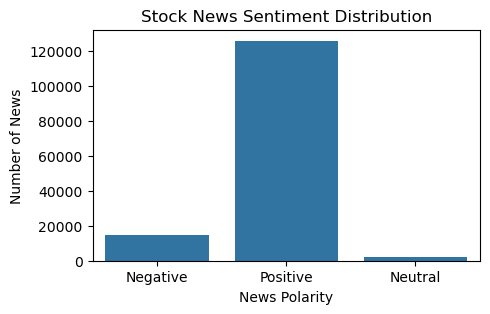

In [7]:
# Plot to visualize the difference in sentiments
plt.figure(figsize = (5,3))
sns.countplot(x = 'sentiment', data = df_original)
plt.title('Stock News Sentiment Distribution')
plt.xlabel('News Polarity')
plt.ylabel('Number of News')

### 1-2. Data Preprocessing

From here, we will perform data preprocessing and assign this DataFrame to df

In [8]:
# Dataframe after data preprocessing
df = df_original.copy()

In [9]:
# Change the data type of 'publishedDate' column into datetime and also make the format uniform(yyyy-mm-dd)
# In the later data preprocessing step, this publishedDate will be removed, but for better readability, we will first convert its format
df['publishedDate'] = pd.to_datetime(df['publishedDate']).dt.strftime('%Y-%m-%d')

In [10]:
# Create a new column in which title and text are combined into one column
df['Title_Text'] = df['title'] + df['text']
df.head()

,symbol,publishedDate,title,image,site,text,url,sentiment,sentimentScore,Title_Text
0,HE,2023-10-04,"HE REMINDER: Kessler Topaz Meltzer & Check, LL...",/next-assets/images/schema-image-default.png,benzinga,"RADNOR, Pa., Oct. 04, 2023 (GLOBE NEWSWIRE) --...",https://www.benzinga.com/pressreleases/23/10/g...,Negative,-0.6417,"HE REMINDER: Kessler Topaz Meltzer & Check, LL..."
1,CRS,2023-10-04,Carpenter Technology Announces Conference Call...,https://ml.globenewswire.com/Resource/Download...,globenewswire,"PHILADELPHIA, Oct. 04, 2023 (GLOBE NEWSWIRE) -...",https://www.globenewswire.com/news-release/202...,Positive,0.4767,Carpenter Technology Announces Conference Call...
2,BB,2023-10-04,What's Going On With BlackBerry Stock After Ho...,https://cdn.benzinga.com/files/images/story/20...,benzinga,BlackBerry Ltd (NYSE: BB) shares are trading h...,https://www.benzinga.com/news/23/10/35098537/w...,Positive,0.9895,What's Going On With BlackBerry Stock After Ho...
3,TECK,2023-10-04,Teck to Release Third Quarter 2023 Results on ...,https://ml.globenewswire.com/Resource/Download...,globenewswire,"VANCOUVER, British Columbia, Oct. 04, 2023 (GL...",https://www.globenewswire.com/news-release/202...,Positive,0.8300,Teck to Release Third Quarter 2023 Results on ...
4,AGF,2023-10-04,AGF Reports September 2023 Assets Under Manage...,/next-assets/images/schema-image-default.png,benzinga,"TORONTO, Oct. 04, 2023 (GLOBE NEWSWIRE) -- AGF...",https://www.benzinga.com/pressreleases/23/10/g...,Positive,0.9768,AGF Reports September 2023 Assets Under Manage...


In [11]:
# Remove columns that are not needed for prediction
df = df.drop(columns = ['symbol', 'publishedDate', 'title', 'image', 'site', 'text', 'url'])

In [12]:
# Check null values in sentimentScore
print("The number of rows where sentimentScore is null:", len(df[df['sentimentScore'].isnull()]))
print("The number of rows where sentimentScore is null and sentiment is Neutral:",len(df[(df['sentimentScore'].isnull() & df['sentiment'] == 'Neutral')]))

print("\nData rows where sentimentScore is null")
df[df['sentimentScore'].isnull()]

The number of rows where sentimentScore is null: 1664
The number of rows where sentimentScore is null and sentiment is Neutral: 0

Data rows where sentimentScore is null


,sentiment,sentimentScore,Title_Text
139928,Positive,NaN,Bed Bath & Beyond Falls as Cohen Files to Sell...
139933,Positive,NaN,bluebird bio's Zynteglo Gets FDA Approval - Li...
139934,Negative,NaN,Wolfspeed Shares Rise High After Q4 Results To...
139939,Positive,NaN,Wabash National Corporation Announces Quarterl...
139940,Positive,NaN,Emclaire Financial Corp Announces Quarterly Di...
...,...,...,...
141995,Positive,NaN,aTyr Pharma Announces Inducement Grants Under ...
141996,Positive,NaN,LMP Automotive Holdings Announces Voluntary NA...
141997,Positive,NaN,Covenant Logistics Group Announces Filing of U...
141998,Positive,NaN,Grindrod Shipping Holdings Ltd. Announces Date...


We can infer the sentiment even without the sentimentScore, so the absence of sentimentScore values is not a critical issue.  
If the sentiment were Neutral, we could replace the sentimentScore with 0, but there are no Neutral cases.  
For Positive and Negative sentiments, we could use the mean value to replace the nulls, but to ensure more accurate fitting, remove the rows with null sentimentScore values instead of replacing them.
However, since there are sufficient data, we will remove the 1,664 rows where sentimentScore is null.

In [13]:
# Remove null values in sentimentScore
df = df.dropna(subset = ['sentimentScore'])

In [14]:
# Performing random sampling as the dataset is too large
df_sampled = df.sample(n=4000, random_state=129)

# Check the size of the sampled data
print(df_sampled.shape)

(4000, 3)


In [15]:
# Convert Dataframe to text data
news_data = df_sampled.to_csv('news_data_sampled.csv', index = False, encoding = 'utf-8')